In [38]:
from keras.models import Sequential
import numpy as np
from keras import layers
from six.moves import range
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import json
import matplotlib.pyplot as plt

# Parameters Config

In [39]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [40]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789* '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [41]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [42]:
ctable = CharacterTable(chars)

In [43]:
ctable.indices_char

{0: ' ',
 1: '*',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [44]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b),reverse=True))
    a,b = key[0],key[1]
    if key in seen:
        continue
    seen.add(key)
    q = '{}*{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a * b)
    ans += ' ' * (DIGITS * 2 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [45]:
print(questions[:5], expected[:5])

['690*464', '57*1   ', '8*5    ', '40*4   ', '459*2  '] ['320160', '57    ', '40    ', '160   ', '918   ']


# Processing

In [46]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS * 2, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS * 2)

Vectorization...


In [47]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:40000]
train_y = y[:40000]
test_x = x[40000:]
test_y = y[40000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(36000, 7, 12)
(36000, 6, 12)
Validation Data:
(4000, 7, 12)
(4000, 6, 12)
Testing Data:
(40000, 7, 12)
(40000, 6, 12)


In [48]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False  True False
   False]
  [False False False False False False False False False False  True
   False]
  [False False False False False False False  True False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False  True False False False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False  True False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False  True False False False False
   False]
  [False False False False False False Fal

# Build Model

In [49]:
from keras import metrics
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(100, input_shape=(MAXLEN, len(chars))))
model.add(RepeatVector(DIGITS*2))
model.add(RNN(80, return_sequences=True))
model.add(TimeDistributed(Dense(12, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               45200     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 6, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 6, 80)             57920     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 12)             972       
Total params: 104,092
Trainable params: 104,092
Non-trainable params: 0
_________________________________________________________________


# Training

In [52]:
print()
print('-' * 50)
#print('Iteration', iteration)
result = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=100,
            validation_data=(x_val, y_val))

def print_result():    
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Train on 36000 samples, validate on 4000 samples
Epoch 1/100
36000/36000 [==============================] - 21s 579us/step - loss: 1.6041 - acc: 0.3821 - val_loss: 1.5518 - val_acc: 0.3974
Epoch 2/100
36000/36000 [==============================] - 20s 568us/step - loss: 1.5145 - acc: 0.4107 - val_loss: 1.4923 - val_acc: 0.4106
Epoch 3/100
36000/36000 [==============================] - 21s 572us/step - loss: 1.4435 - acc: 0.4313 - val_loss: 1.4130 - val_acc: 0.4434
Epoch 4/100
36000/36000 [==============================] - 21s 577us/step - loss: 1.3948 - acc: 0.4470 - val_loss: 1.3777 - val_acc: 0.4449
Epoch 5/100
36000/36000 [==============================] - 21s 578us/step - loss: 1.3676 - acc: 0.4571 - val_loss: 1.3503 - val_acc: 0.4675
Epoch 6/100
36000/36000 [==============================] - 21s 578us/step - loss: 1.3401 - acc: 0.4680 - val_loss: 1.3296 - val_acc: 0.4696
Epoch 7/100
36000/36000 [==============================] - 

36000/36000 [==============================] - 20s 567us/step - loss: 0.7727 - acc: 0.7004 - val_loss: 0.8341 - val_acc: 0.6681
Epoch 59/100
36000/36000 [==============================] - 21s 573us/step - loss: 0.7643 - acc: 0.7052 - val_loss: 0.8119 - val_acc: 0.6802
Epoch 60/100
36000/36000 [==============================] - 21s 583us/step - loss: 0.7558 - acc: 0.7099 - val_loss: 0.8167 - val_acc: 0.6672
Epoch 61/100
36000/36000 [==============================] - 21s 585us/step - loss: 0.7657 - acc: 0.7024 - val_loss: 0.7841 - val_acc: 0.6923
Epoch 62/100
36000/36000 [==============================] - 21s 588us/step - loss: 0.7633 - acc: 0.7032 - val_loss: 0.8149 - val_acc: 0.6822
Epoch 63/100
36000/36000 [==============================] - 22s 599us/step - loss: 0.7493 - acc: 0.7110 - val_loss: 0.7733 - val_acc: 0.6950
Epoch 64/100
36000/36000 [==============================] - 21s 579us/step - loss: 0.7532 - acc: 0.7078 - val_loss: 0.7961 - val_acc: 0.6808
Epoch 65/100
36000/36000 [

Text(0,0.5,'Accuracy')

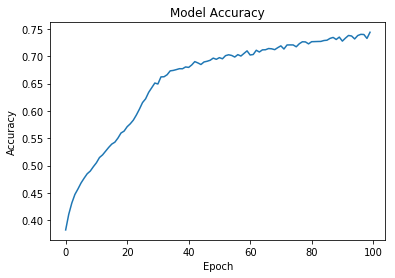

In [53]:
plt.plot(result.history['acc'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [54]:
with open('DIGIT-3(mul,training_size = 36000).json','w') as f:
    json.dump(result.history,f)

# Testing

In [55]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
accur = 0 
for i in range(len(test_x)):
    ind = i
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if i % 1000 == 0:
        print(i)
    if correct == guess:
        accur += 1
accur = accur / len(test_x)
print("Accuracy: ",accur)

MSG : Prediction
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
Accuracy:  0.124425


In [56]:
fp = open("Accuracy(mul,training_size = 36000).txt", "a")
fp.write(str(accur)+'\n')
fp.close()

# Analysis
### 1.Training data size = 36000
### 2.Validation data size = 4000
### 3.Test data size = 40000

In [59]:
with open('DIGIT-3(mul,training_size = 36000).json','r') as f:
    result = json.load(f)

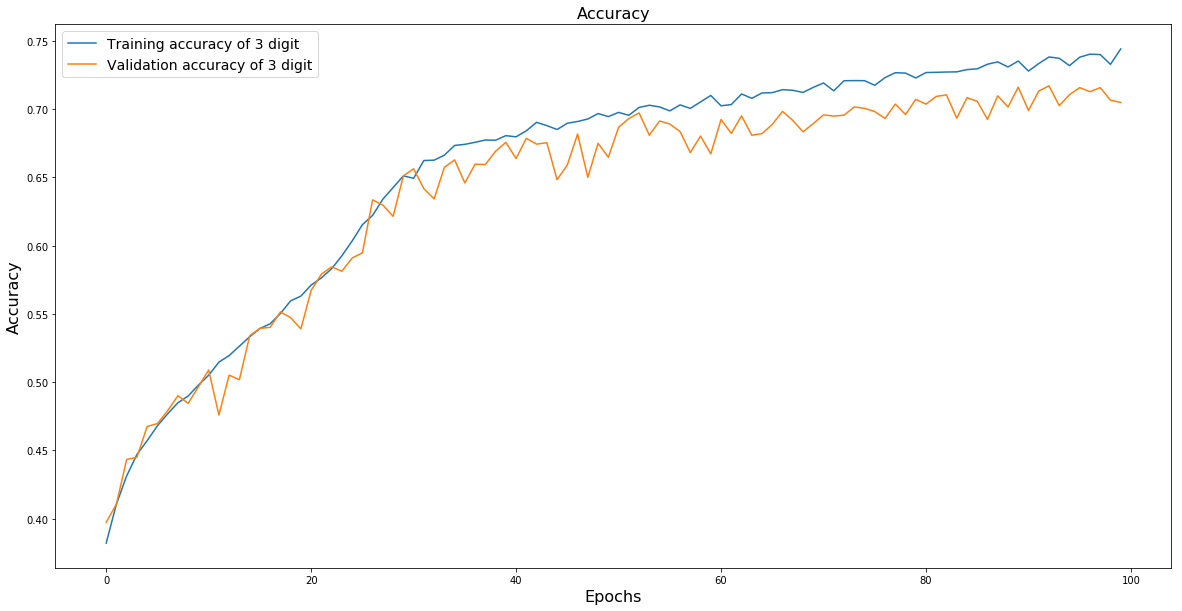

In [60]:
plt.figure(figsize=(20,10))
acc = result['acc']
val_acc = result['val_acc']
plt.plot(acc, label='Training accuracy of 3 digit')
plt.plot(val_acc, label='Validation accuracy of 3 digit')
plt.title('Accuracy',fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [61]:
Accuracy_data = open('Accuracy(mul,training_size = 36000).txt','r')
io = Accuracy_data.readlines()
print("Test accuracy of 3 digit is ",io[0][:-1])

Test accuracy of 3 digit is  0.124425


## Conclusion
- Multiplication 部分直接將 training data size 變為 36000 做實驗，結果發現 model overfitting 了，training accuracy 跟 validation accuracy 很高，但最後的 test accuracy 卻只有 0.124425